# Clonotype and sequence diversity

Here we will make the following figures:

  * Rarefaction curve (**Figure 3a**)
  * Clonotype diversity estimates (**Figure 3b**)
  * Sequence diversity estimates (**Figure 3c**)
  
The raw data used to make these plots can be found [**here**](https://www.ncbi.nlm.nih.gov/sra/PRJNA592154).

The following Python packages are required to run the code in this notebook:
  * numpy
  * pandas
  * matplotlib
  * seaborn
  * [abutils](https://www.github.com/briney/abutils)

They can be install by running `pip install numpy pandas matplotlib seaborn abutils`

In [24]:
from __future__ import print_function, division

import os
import subprocess as sp
import sys
import tempfile
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from abutils.utils.pipeline import list_files, make_dir
from abutils.utils.progbar import progress_bar

%matplotlib inline

## Rarefaction curve 

To plot the number of unique OmniRat clonotypes against the total sample size for each animal.

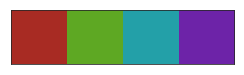

In [25]:
#Dictionary of collection groups
collection_groups = {'OR1': ['OR1_LN', 'OR1_Spleen'],
                     'OR2': ['OR2_LN', 'OR2_Spleen'],
                     'OR3': ['OR3_LN', 'OR3_Spleen']}

# subjects
subjects = collection_groups.keys()
    
# input file
input_path = '../Data/dedup_data/equal_fraction_downsampling'
input_filename = 'clonotype-downsampling_duplicate-counts_vj-aa.txt'
input_file = os.path.join(input_path, input_filename)

# colors
colors = sns.hls_palette(4, l=0.4)


color_dict = {s: c for s, c in zip(subjects, colors)}

sns.palplot(colors)

In [7]:
with open(input_file) as f:
    data = f.read()

xs, ys = [], []
for subject_chunk in data.split('#')[1:]:
    xdata = []
    ydata = []
    subject = subject_chunk.split('>')[0].strip()
    for fraction in subject_chunk.split('>')[1:]:
        frac = float(fraction.split('\n')[0].strip())
        yvals = []
        for iteration in fraction.split('\n')[1:]:
            if not iteration.strip():
                continue
            l = [i.strip().split(':') for i in iteration.strip().split()]
            c = {int(k): float(v) for k, v in l}
            obs = float(sum(c.values()))
            total = float(sum([k * v for k, v in c.items()]))
            yval = obs / total * frac
            yvals.append(yval)
        ydata.append(np.mean(yvals))
        xdata.append(frac)
    xs.append(xdata)
    ys.append(ydata)

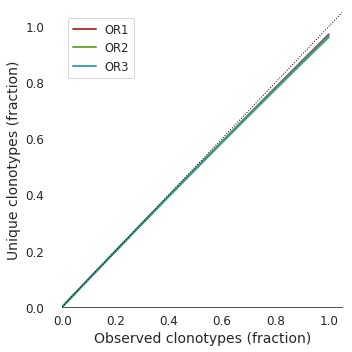

In [8]:
# initialize plot
sns.set_style('white')
plt.figure(figsize=(5, 5))

# plot rarefaction data
for xdata, ydata, subject, color in zip(xs, ys, subjects, colors):
    plt.plot([0] + xdata, [0] + ydata, c=color, label=subject, linewidth=2, alpha=0.9)

# plot diagonal reference line
plt.plot((0, 1.1), (0, 1.1), 'k:', linewidth=1)

# style the plot
ax = plt.gca()
# plot legend
ax.legend(loc='upper left', fontsize=11.5)
# set axis limits and labels
ax.set_xlim((0, 1.05))
ax.set_ylim((0, 1.05))
ax.set_xlabel('Observed clonotypes (fraction)', fontsize=14)
ax.set_ylabel('Unique clonotypes (fraction)', fontsize=14)
# style ticks
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=12, right=False)
# hide top, left and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.tight_layout()

#plt.savefig('./figures/figure3a', dpi=800)

plt.show()

## Clonotype diversity estimates

To calculate OmniRat clonotype diversity with Chao 2 and Recon for each animal.

In [38]:
# input data location
data_path = '../Data/calculated_diversity-estimation'

# read Chao2 data
chao_file = os.path.join(data_path, 'single-subject_sequences_chao2.json')
with open(chao_file) as f:
    chao_diversity = json.load(f)
    
# read Recon data
recon_file = os.path.join(data_path, 'single-subject_sequences_recon.json')
with open(recon_file) as f:
    recon_diversity = json.load(f)

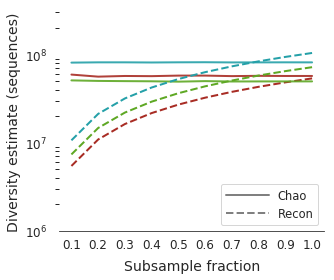

In [39]:
# initialize the plot
sns.set_style('white')
plt.figure(figsize=(4.75, 4))
plots = []

# plot the diversity data
for color, subject in zip(colors, subjects):
    x = sorted(chao_diversity[subject].keys())
    _x = ['0.1',
         '0.2',
         '0.3',
         '0.4',
         '0.5',
         '0.6',
         '0.7',
         '0.8',
         '0.9',
         '1.0']
    chao_ys = [np.mean(chao_diversity[subject][k]) for k in x]
    recon_ys = [np.mean(recon_diversity[subject][k]) for k in x]

    plot = plt.plot(_x, chao_ys, c=color, alpha=0.9, linewidth=2, label=subject)
    plt.plot(_x, recon_ys, c=color, linestyle='dashed', linewidth=2)
    plots.append(plot)

# style the plot
ax = plt.gca()
# axis limits and scale
ax.set_yscale("log")
ax.set_ylim([10**6, 3 * 10**8])
# style ticks
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=6, right=False)
ax.tick_params(axis='y', which='minor', left=True, right=False, length=4, width=1, pad=8)
# hide top, left and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# axis lables
ax.set_ylabel('Diversity estimate (sequences)', size=14)
ax.set_xlabel('Subsample fraction', size=14, labelpad=8)
# plot the legend
chao_proxy = mpl.lines.Line2D([0], [0], color='grey', linewidth=2)
recon_proxy = mpl.lines.Line2D([0], [0], linestyle='dashed', color='grey', linewidth=2)
ax.legend([chao_proxy, recon_proxy], ['Chao', 'Recon'],
          loc='lower right', fontsize=11.5, handlelength=3.75)

plt.tight_layout()

plt.savefig('./figures/figure3b', dpi=800)

plt.show()

In [30]:
recon_maxes = [{'subject': subject,
                'Diversity estimate (sequences)': np.mean(recon_diversity[subject]['1.0']),
                'estimator': 'R'} for subject in subjects]

chao_maxes = [{'subject': subject,
               'Diversity estimate (sequences)': np.mean(chao_diversity[subject]['1.0']),
               'estimator': 'C'} for subject in subjects]

max_df = pd.DataFrame(recon_maxes + chao_maxes)

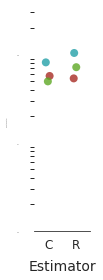

In [31]:
# initialize the plot
sns.set_style('white')
plt.figure(figsize=(1.5, 4))

# plot the data
sns.stripplot(data=max_df,
              x='estimator',
              y='Diversity estimate (sequences)',
              hue='subject',
              order=['C', 'R'],
              size=8,
              palette={s: c for s, c in zip(subjects, colors)},
              jitter=True,
              alpha=0.8)

# style the plot
ax = plt.gca()
# remove legend
ax.legend_.remove()
# set axis scales, limits and labels
ax.set_yscale("log")
ax.set_ylim([10**6, 3 * 10**8])
ax.set_xlabel('Estimator', size=14, labelpad=8)
ax.set_ylabel('Clonotype fraction', size=0, labelpad=8)
# style ticks
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=0, length=6, width=1.25, pad=8, right=False)
ax.tick_params(axis='y', which='minor', left=True, right=False, length=4, width=1, pad=8)
# remove top, left and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/figure3b-side', dpi=800)

plt.show()

## Sequence diversity estimates

To calculate OmniRat sequence diversity with Chao 2 and Recon for each animal.

In [40]:
# input data location
data_path = '../Data/calculated_diversity-estimation'

# read Chao2 data
chao_file = os.path.join(data_path, 'single-subject_clonotypes_chao2.json')
with open(chao_file) as f:
    chao_diversity = json.load(f)
    
# read Recon data
recon_file = os.path.join(data_path, 'single-subject_clonotypes_recon.json')
with open(recon_file) as f:
    recon_diversity = json.load(f)

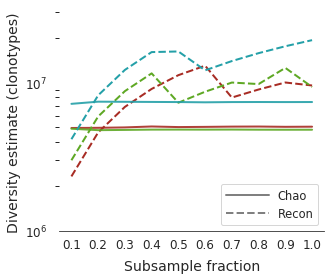

In [41]:
# initialize the plot
sns.set_style('white')
plt.figure(figsize=(4.75, 4))
plots = []

# plot the diversity data
for color, subject in zip(colors, subjects):
    x = sorted(chao_diversity[subject].keys())
    _x = ['0.1',
         '0.2',
         '0.3',
         '0.4',
         '0.5',
         '0.6',
         '0.7',
         '0.8',
         '0.9',
         '1.0']
    chao_ys = [np.mean(chao_diversity[subject][k]) for k in x]
    recon_ys = [np.mean(recon_diversity[subject][k]) for k in x]

    plot = plt.plot(_x, chao_ys, c=color, alpha=0.9, linewidth=2, label=subject)
    plt.plot(_x, recon_ys, c=color, linestyle='dashed', linewidth=2)
    plots.append(plot)

# style the plot
ax = plt.gca()
# axis limits and scale
ax.set_yscale("log")
ax.set_ylim([10**6, 1.5 * 10**7.3])
# style ticks
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=6, right=False)
ax.tick_params(axis='y', which='minor', left=True, right=False, length=4, width=1, pad=8)
# hide top, left and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# axis lables
ax.set_ylabel('Diversity estimate (clonotypes)', size=14)
ax.set_xlabel('Subsample fraction', size=14, labelpad=8)
# plot the legend
chao_proxy = mpl.lines.Line2D([0], [0], color='grey', linewidth=2)
recon_proxy = mpl.lines.Line2D([0], [0], linestyle='dashed', color='grey', linewidth=2)
ax.legend([chao_proxy, recon_proxy], ['Chao', 'Recon'],
          loc='lower right', fontsize=11.5, handlelength=3.75)

plt.tight_layout()

plt.savefig('./figures/figure3c', dpi=800)

plt.show()

In [42]:
recon_maxes = [{'subject': subject,
                'Diversity estimate (clonotypes)': np.mean(recon_diversity[subject]['1.0']),
                'estimator': 'R'} for subject in subjects]

chao_maxes = [{'subject': subject,
               'Diversity estimate (clonotypes)': np.mean(chao_diversity[subject]['1.0']),
               'estimator': 'C'} for subject in subjects]

max_df = pd.DataFrame(recon_maxes + chao_maxes)

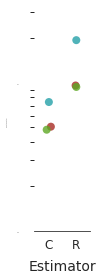

In [43]:
# initialize the plot
sns.set_style('white')
plt.figure(figsize=(1.5, 4))

# plot the data
sns.stripplot(data=max_df,
              x='estimator',
              y='Diversity estimate (clonotypes)',
              hue='subject',
              order=['C', 'R'],
              size=8,
              palette={s: c for s, c in zip(subjects, colors)},
              jitter=True,
              alpha=0.8)

# style the plot
ax = plt.gca()
# remove legend
ax.legend_.remove()
# set axis scales, limits and labels
ax.set_yscale("log")
ax.set_ylim([10**6, 1.5 * 10**7.3])
ax.set_xlabel('Estimator', size=14, labelpad=8)
ax.set_ylabel('Clonotype fraction', size=0, labelpad=8)
# style ticks
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=0, length=6, width=1.25, pad=8, right=False)
ax.tick_params(axis='y', which='minor', left=True, right=False, length=4, width=1, pad=8)
# remove top, left and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/figure3c-side', dpi=800)

plt.show()